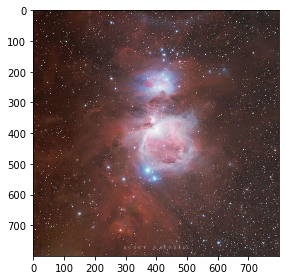

In [19]:
#Setup

import sys
import skimage.io
import numpy as np
import skimage.color
from matplotlib import pyplot as plt

flie_name = "orion_nebula.jpeg"
graph_smooth = False
graph_log = True

image = skimage.io.imread(fname=flie_name)
skimage.io.imshow(image)

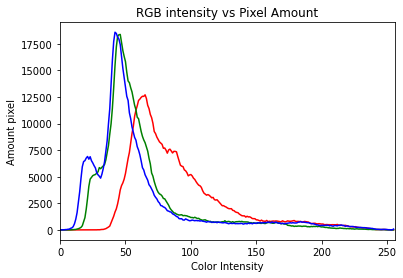

In [20]:
# tuple to select colors of each channel line
colors = ("red", "green", "blue")
channel_ids = (0, 1, 2)

plt.xlim([0, 256])
for channel_id, c in zip(channel_ids, colors):
    histogram, bin_edges = np.histogram(
        image[:, :, channel_id], bins=256, range=(0, 256)
    )
    plt.plot(bin_edges[0:-1], histogram, color=c)

plt.xlabel("Color Intensity")
plt.ylabel("Amount pixel")
plt.title("RGB intensity vs Pixel Amount")
plt.show()

In [21]:
#RGB extract

from PIL import Image

im = Image.open(flie_name) # Can be many different formats.
pix = im.load()
print(im.size)  # Get the width and hight of the image for iterating over

sizex = im.size[0]
sizey = im.size[1]

x = []
y = []
r = []
g = []
b = []

for cx in range(sizex):
    for cy in range(sizey):
        x.append(cx)
        y.append(cx)
        r.append(pix[cx,cy][0])
        g.append(pix[cx,cy][1])
        b.append(pix[cx,cy][2])
        
#print(r)
#print(pix[1,1])



(800, 800)


In [13]:
# RGB to HSV
import colorsys

pixel_amount = im.size[0] * im.size[1]

hsv = []
hue = []
saturation = []
value = []
print("Pixel Count = ", len(r))

for i in range(len(r)):
    for k in range(3):
        hsv.append(colorsys.rgb_to_hsv(r[i],g[i],b[i])[k])
    
    hue.append(hsv[0])
    saturation.append(hsv[1])
    value.append(hsv[2])
    hsv = []


Pixel Count =  640000


In [14]:
#HSV to Wavelength and Intensity

wavelength = []
main_tone = 0

for i in range(len(hue)):
    if 360* (hue[i]) <= 60:
        main_tone = (630 - 250 * hue[i]) + 120 * (value[i]/255)
        wavelength.append(round(main_tone,0))
    elif 360* (hue[i]) <= 120:
        main_tone = (630 - 250 * hue[i]) + 82.5 * saturation[i] 
        wavelength.append(round(main_tone,0))
    elif 360* (hue[i]) <= 180:
        main_tone = (630 - 250 * hue[i]) + 33.5 * saturation[i] 
        wavelength.append(round(main_tone,0))
    elif 360* (hue[i]) <= 240:
        main_tone = (630 - 250 * hue[i]) - 33.5 * saturation[i] 
        wavelength.append(round(main_tone,0))
    elif 360* (hue[i]) <= 240:
        main_tone = (630 - 250 * hue[i])
        wavelength.append(round(main_tone,0)) - 82.5 * saturation[i] 
    else:
        main_tone = (630 - 250 * hue[i]) + 120 * (value[i]/255)
        wavelength.append(round(main_tone,0))


In [15]:
#Wavelength Mapping
plot = {}

for i in range(len(wavelength)):
    plot.update({wavelength[i]:0})

for i in range(len(wavelength)):
    p = plot[wavelength[i]]
    plot[wavelength[i]]= p + value[i]

sorted_plot = dict(sorted(plot.items(), key=lambda item: item[0]))

est_intensity = list(sorted_plot.values())
est_wavelength = list(sorted_plot.keys())

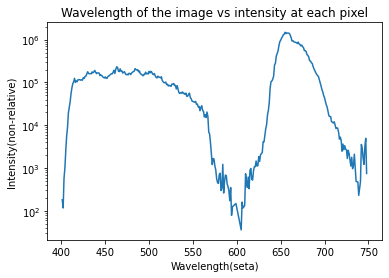

In [16]:
#Graph Wavelength
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter

x = np.array(est_wavelength)
y = np.array(est_intensity)

window = 21
order = 7
y_sf = savgol_filter(y, window, order)

if graph_smooth == True:
    plt.plot(x,y_sf)
else:
    plt.plot(x,y)
    
    
if graph_log == True:
    plt.yscale("log")
else:
    pass

plt.title("Wavelength of the image vs intensity at each pixel")
plt.xlabel("Wavelength(seta)")
plt.ylabel("Intensity(non-relative)")
plt.show()

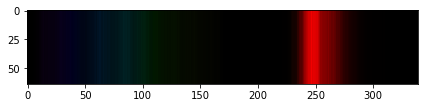

In [17]:
#Spectum graph generate

from PIL import Image
import sys
import os
import traceback
import optparse
import time
import logging
import math

magnitude_scale = 2
image_brightness = 0.8

def wavelength_to_rgb(wavelength, gamma=image_brightness):
    wavelength = float(wavelength)
    if wavelength >= 380 and wavelength <= 440:
        attenuation = 0.3 + 0.7 * (wavelength - 380) / (440 - 380)
        R = ((-(wavelength - 440) / (440 - 380)) * attenuation) ** gamma
        G = 0.0
        B = (1.0 * attenuation) ** gamma
    elif wavelength >= 440 and wavelength <= 490:
        R = 0.0
        G = ((wavelength - 440) / (490 - 440)) ** gamma
        B = 1.0
    elif wavelength >= 490 and wavelength <= 510:
        R = 0.0
        G = 1.0
        B = (-(wavelength - 510) / (510 - 490)) ** gamma
    elif wavelength >= 510 and wavelength <= 580:
        R = ((wavelength - 510) / (580 - 510)) ** gamma
        G = 1.0
        B = 0.0
    elif wavelength >= 580 and wavelength <= 645:
        R = 1.0
        G = (-(wavelength - 645) / (645 - 580)) ** gamma
        B = 0.0
    elif wavelength >= 645 and wavelength <= 750:
        attenuation = 0.3 + 0.7 * (750 - wavelength) / (750 - 645)
        R = (1.0 * attenuation) ** gamma
        G = 0.0
        B = 0.0
    else:
        R = 0.0
        G = 0.0
        B = 0.0
    R *= 255
    G *= 255
    B *= 255
    return (int(R), int(G), int(B))

colors = []

width = len(est_wavelength)
height = 64

color_data = []
combine = []
temp_r = 0
temp_g = 0
temp_b = 0
max_intensity = max(est_intensity)

for i in range(len(est_wavelength)):
    color_data = wavelength_to_rgb(est_wavelength[i])
    combine.append(int(round(color_data[0] * (est_intensity[i])/(max_intensity),0)))
    combine.append(int(round(color_data[1] * (est_intensity[i])/(max_intensity),0)))
    combine.append(int(round(color_data[2] * (est_intensity[i])/(max_intensity),0)))
    colors.append(tuple(combine))
    combine = []

colors = colors * height

timestr = time.strftime("%Y%m%d-%H%M%S")
FILE_NAMEs = 'Spectumdata'+timestr+'.png'

im = Image.new("RGB", (width, height))
im.putdata(colors)
im.save(FILE_NAMEs)

output = skimage.io.imread(fname=FILE_NAMEs)
skimage.io.imshow(output)

In [18]:
pass